# Diabetic Retinopathy Detection using CapsNet and ViT (APTOS 2019)
This notebook:
- Loads the APTOS 2019 dataset
- Implements CapsNet and ViT models in PyTorch
- Trains both models separately
- Evaluates them using Accuracy, Precision, Recall, and F1 Score, Confusion Matrix
- Combines both models in an ensemble for improved performance

## Installations & Importations

In [ ]:
!pip install -q vit-pytorch scikit-learn torchvision einops

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from vit_pytorch import ViT
from einops import rearrange, repeat

## Préparation du Dataset

In [3]:
# Dataset preparation
df = pd.read_csv('/kaggle/input/aptos-mini/train_images.csv')
df['image_path'] = df['id_code'].apply(lambda x: f"/kaggle/input/aptos-mini/train_images/{x}.png")

class RetinopathyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        image = Image.open(self.dataframe.iloc[idx]['image_path']).convert('RGB')
        label = self.dataframe.iloc[idx]['diagnosis']
        if self.transform:
            image = self.transform(image)
        return image, label

## Organisation des Dataframes de Train/ Test

In [4]:
# Transforms and loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
train_ds = RetinopathyDataset(train_df, transform)
val_ds = RetinopathyDataset(val_df, transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

## Création du ViT

In [5]:
# Vision Transformer model
vit = ViT(
    image_size=224,
    patch_size=32,
    num_classes=5,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=1024,
    channels=3
).cuda()

## Création du modèle  CapsNet

In [6]:
# Simple Capsule Network
class SimpleCapsNet(nn.Module):
    def __init__(self):
        super(SimpleCapsNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 9, stride=1)
        self.primary_caps = nn.Conv2d(256, 32 * 8, kernel_size=9, stride=2)

        # Initialize fc later after knowing flattened size
        self.fc = None

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.primary_caps(x)
        x = x.view(x.size(0), -1)

        # Lazy initialization of fc
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 5).to(x.device)

        x = self.fc(x)
        return x

capsnet = SimpleCapsNet().cuda()

## Fonction d'entraînement des modèles avec affichage des graphiques

In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, model_name="model", epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.cuda(), labels.cuda()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # Plotting
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"Loss - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"loss_accuracy_plot_{model_name}.png")
    plt.savefig(f"loss_accuracy_plot_{model_name}.svg")
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies


## Boucle d'entraînement de chaque modèle

Epoch 1/5: Train Loss=1.9464, Acc=0.2675 | Val Loss=1.6235, Acc=0.2600
Epoch 2/5: Train Loss=1.4116, Acc=0.3900 | Val Loss=1.3511, Acc=0.4200
Epoch 3/5: Train Loss=1.2597, Acc=0.4525 | Val Loss=1.2974, Acc=0.4300
Epoch 4/5: Train Loss=1.2316, Acc=0.4925 | Val Loss=1.1241, Acc=0.4400
Epoch 5/5: Train Loss=1.1190, Acc=0.5275 | Val Loss=1.1978, Acc=0.4200


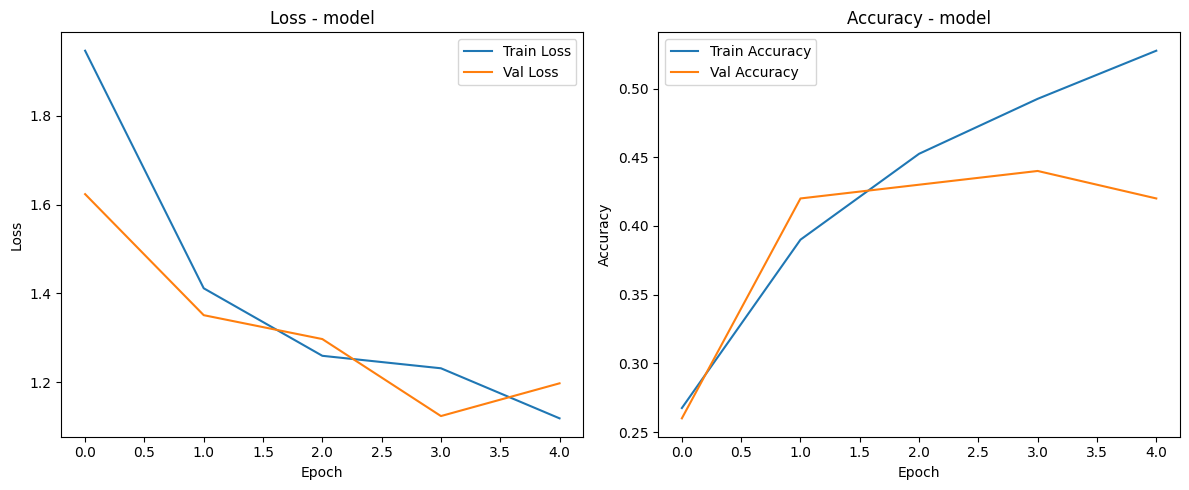

Epoch 1/5: Train Loss=1.6762, Acc=0.2775 | Val Loss=1.3428, Acc=0.4600
Epoch 2/5: Train Loss=1.3173, Acc=0.4775 | Val Loss=1.1985, Acc=0.4500
Epoch 3/5: Train Loss=1.2301, Acc=0.4700 | Val Loss=1.1386, Acc=0.5300
Epoch 4/5: Train Loss=1.1824, Acc=0.5000 | Val Loss=1.1697, Acc=0.5000
Epoch 5/5: Train Loss=1.1758, Acc=0.5075 | Val Loss=1.1339, Acc=0.5000


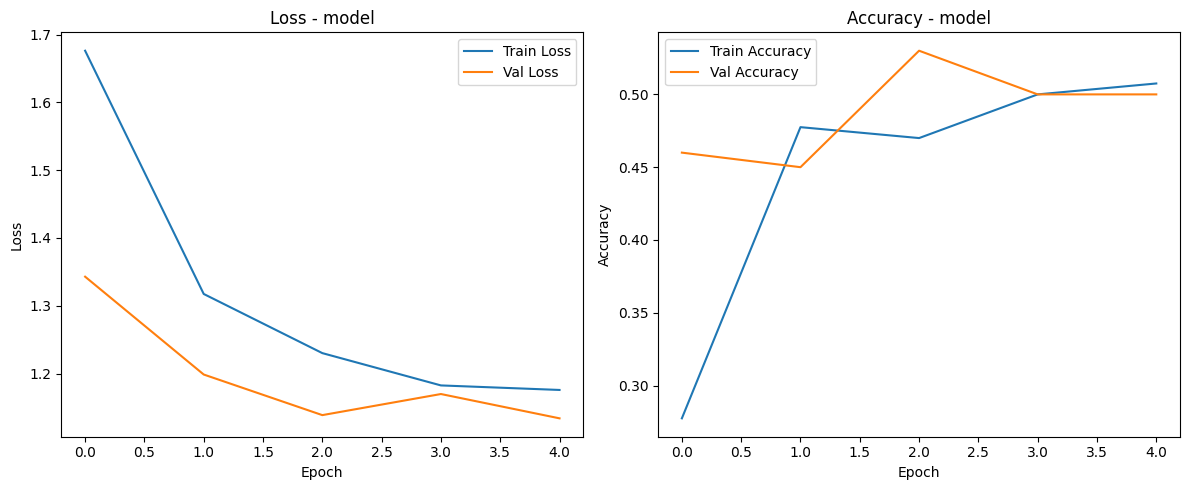

([1.6761633249429555,
  1.3173452524038463,
  1.2300910720458398,
  1.1824426651000977,
  1.175754019847283],
 [1.3428364396095276,
  1.198517546057701,
  1.1386315524578094,
  1.1697491258382797,
  1.133883386850357],
 [0.2775, 0.4775, 0.47, 0.5, 0.5075],
 [0.46, 0.45, 0.53, 0.5, 0.5])

In [8]:
# Train ViT and CapsNet
train_model(vit, train_loader, val_loader)
train_model(capsnet, train_loader, val_loader)

## Enregistrement des modèles entraînés

In [9]:
# Sauvegarde
torch.save(vit, 'model_vit_full.pth')
torch.save(capsnet, 'model_capsnet_full.pth')


# Chargement
#model = torch.load('model_full.pth')
#model = torch.load('model_full.pth')


## Enregistrement des poids et des biais des modèles

In [ ]:
# Sauvegarde
torch.save(vit.state_dict(), 'model_vit.pth')
torch.save(capsnet.state_dict(), 'model_capsnet.pth')


# Chargement
model1 = ViT()
model1.load_state_dict(torch.load('model_vit.pth'))

model2 = SimpleCapsNet()
model2.load_state_dict(torch.load('model_capsnet.pth'))


## Evaluations des deux modèles

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.savefig(f"{title.replace(' ', '_')}.svg")
    plt.show()

def evaluate_sep(models, loader, class_names=None, loss_histories=None, acc_histories=None):
    y_true_all = []
    y_preds_ensemble = []

    print("🔍 Individual Model Metrics:\n")
    for i, model in enumerate(models):
        model.eval()
        y_true, y_preds = [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.cuda()
                outputs = model(imgs)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                y_preds.extend(preds)
                y_true.extend(labels.numpy())

        print(f"Model {i+1}:")
        print(classification_report(y_true, y_preds, target_names=class_names) if class_names else classification_report(y_true, y_preds))
        print("Accuracy:", accuracy_score(y_true, y_preds))
        print("Precision:", precision_score(y_true, y_preds, average='weighted'))
        print("Recall:", recall_score(y_true, y_preds, average='weighted'))
        print("F1 Score:", f1_score(y_true, y_preds, average='weighted'))
        plot_confusion_matrix(y_true, y_preds, title=f"Confusion Matrix - Model {i+1}", class_names=class_names)
        print("="*60)

        if i == 0:
            y_true_all = y_true  # Save once for ensemble comparison

    # Ensemble evaluation
    print("\n Ensemble Model Metrics:\n")
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda()
            ensemble_output = sum([F.softmax(m(imgs), dim=1) for m in models]) / len(models)
            preds = torch.argmax(ensemble_output, dim=1).cpu().numpy()
            y_preds_ensemble.extend(preds)

    print(classification_report(y_true_all, y_preds_ensemble, target_names=class_names) if class_names else classification_report(y_true_all, y_preds_ensemble))
    print("Accuracy:", accuracy_score(y_true_all, y_preds_ensemble))
    print("Precision:", precision_score(y_true_all, y_preds_ensemble, average='weighted'))
    print("Recall:", recall_score(y_true_all, y_preds_ensemble, average='weighted'))
    print("F1 Score:", f1_score(y_true_all, y_preds_ensemble, average='weighted'))
    plot_confusion_matrix(y_true_all, y_preds_ensemble, title="Confusion Matrix - Ensemble", class_names=class_names)

    # Plot training curves if provided
    if loss_histories and acc_histories:
        plt.figure(figsize=(12, 5))

        # Loss
        plt.subplot(1, 2, 1)
        for i, loss in enumerate(loss_histories):
            plt.plot(loss, label=f'Model {i+1}')
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Accuracy
        plt.subplot(1, 2, 2)
        for i, acc in enumerate(acc_histories):
            plt.plot(acc, label=f'Model {i+1}')
        plt.title("Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.savefig("training_curves.png")
        plt.savefig("training_curves.svg")
        plt.show()

## Affichage des résultats combinés

🔍 Individual Model Metrics:

Model 1:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.50      0.50      0.50        20
           2       0.00      0.00      0.00        20
           3       0.30      0.65      0.41        20
           4       0.27      0.15      0.19        20

    accuracy                           0.42       100
   macro avg       0.40      0.42      0.39       100
weighted avg       0.40      0.42      0.39       100

Accuracy: 0.42
Precision: 0.4018716577540107
Recall: 0.42
F1 Score: 0.3929326503923277


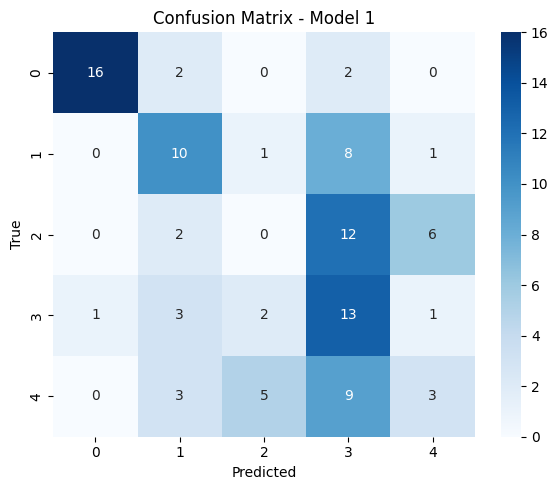

Model 2:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.39      0.75      0.52        20
           2       0.40      0.50      0.44        20
           3       0.38      0.25      0.30        20
           4       0.50      0.20      0.29        20

    accuracy                           0.50       100
   macro avg       0.54      0.50      0.49       100
weighted avg       0.54      0.50      0.49       100

Accuracy: 0.5
Precision: 0.5358704453441295
Recall: 0.5
F1 Score: 0.4878638602776534


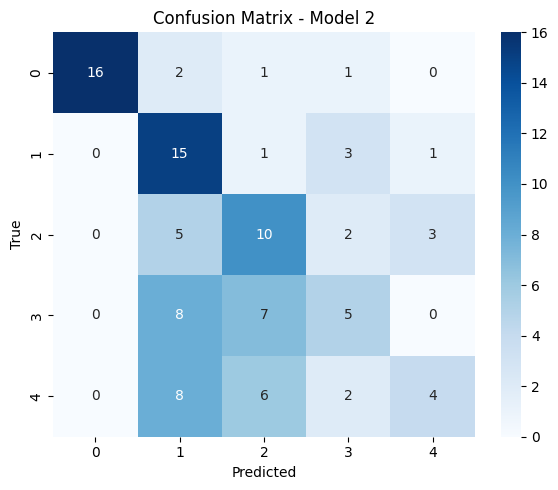


 Ensemble Model Metrics:

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.48      0.80      0.60        20
           2       0.36      0.20      0.26        20
           3       0.37      0.55      0.44        20
           4       0.30      0.15      0.20        20

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.48       100
weighted avg       0.50      0.50      0.48       100

Accuracy: 0.5
Precision: 0.503030303030303
Recall: 0.5
F1 Score: 0.4781453979847163


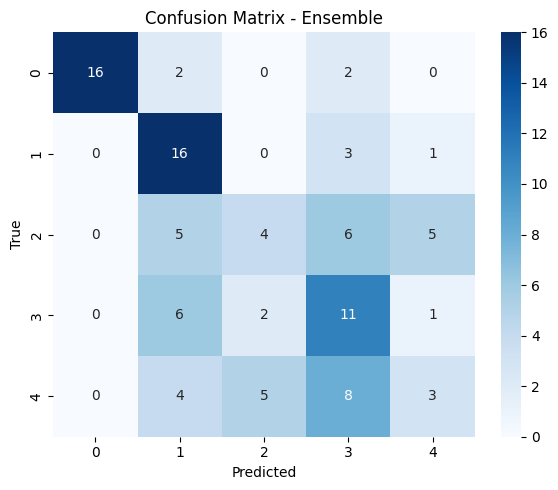

In [14]:
# Run evaluation
evaluate_sep([vit, capsnet], val_loader)